In [1]:
from RoutePlanner.CellGrid import CellGrid
from RoutePlanner.IO import LoadIcePoints, LoadCurrentPoints
from RoutePlanner.Optimisation import TravelTime

import pandas as pd
import numpy as np

from simplekml import Kml, Color, Style

In [2]:
OptInfo = {}
X     = [230,360]
Y     = [-80,-40]
d     = [5,2.5]
OptInfo['Start Time']           = '2017-03-15'
OptInfo['End Time']             = '2017-03-16'
OptInfo['WayPoints']            = pd.read_csv('../../resources/WayPoints.csv') 
OptInfo['MaxIceExtent']         = 0.8
OptInfo['Zero Currents']        = True
OptInfo['VariableSpeed']        = True
OptInfo['Time Unit']            = 'days'
OptInfo['VehicleInfo']          = {}
OptInfo['VehicleInfo']['Speed'] = 26.3
OptInfo['VehicleInfo']['Unit']  = 'km/hr'
OptInfo['Start Waypoints']      = ['Palmer']

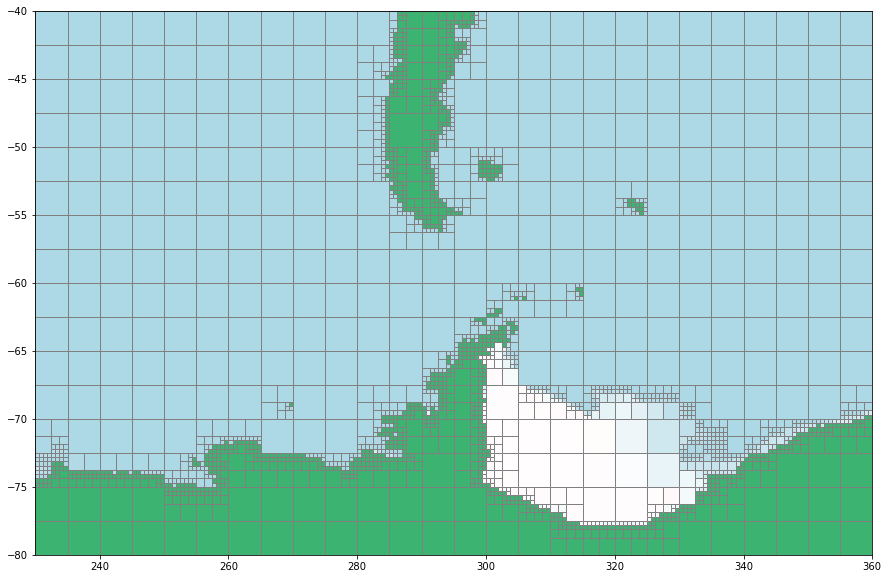

In [3]:
icePoints     = LoadIcePoints('../../Data/bsose_i122_2013to2017_1day_SeaIceArea.nc',OptInfo['Start Time'],OptInfo['End Time'])
currentPoints = LoadCurrentPoints('../../Data/SOSE_surface_velocity_6yearMean_2005-2010.nc')

cellGrid = CellGrid(X[0],X[1],Y[0],Y[1],d[0],d[1])
cellGrid.addIcePoints(icePoints)
cellGrid.addCurrentPoints(currentPoints)
cellGrid.recursiveSplit(3)
cellGrid.plot()

In [4]:
TT = TravelTime(cellGrid,OptInfo)
TT.Dijkstra(verbrose=True)

=== Processing Waypoint = Palmer ===


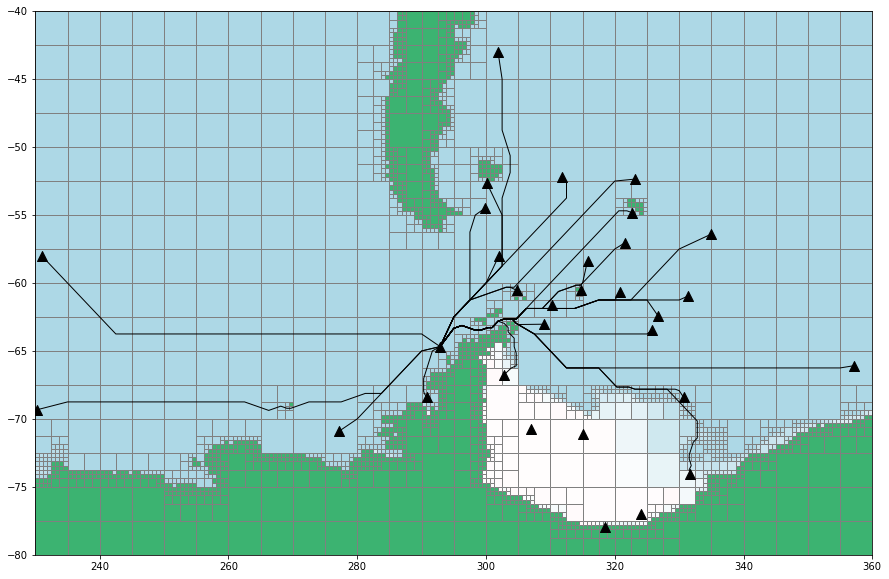

In [5]:
ax = TT.PlotPaths(TT.Paths)


In [6]:
TT.PathSmoothing(maxiter=50)

 PATH: Palmer -> Falklands 
Sp=(292.86694444444447,-64.67861111111111);Cp=(295.0,-62.5);Np=(300.0,-60.0)
Box1=(-63.589305555555555,293.93347222222224);Box2=(-61.25,297.5)
Sp=(295.0,-63.333333333333336);Cp=(296.6666666666667,-62.5);Np=(300.0,-60.0)
Box1=(-62.91666666666667,295.83333333333337);Box2=(-61.25,298.33333333333337)
Sp=(296.7724280931495,-62.5);Cp=(300.0,-60.0);Np=(302.5,-57.5)
Box1=(-61.25,298.38621404657476);Box2=(-58.75,301.25)
Sp=(297.5,-60.0);Cp=(300.0,-58.75);Np=(302.5,-57.5)
Box1=(-59.375,298.75);Box2=(-58.125,301.25)
Sp=(300.0,-58.87900260742331);Cp=(302.5,-57.5);Np=(302.5,-55.0)
Box1=(-58.18950130371165,301.25);Box2=(-56.25,302.5)
Sp=(301.0042428663417,-57.5);Cp=(302.5,-55.0);Np=(300.12,-52.63472222222222)
Box1=(-56.25,301.7521214331708);Box2=(-53.81736111111111,301.31)
Sp=(292.86694444444447,-64.67861111111111);Cp=(295.0,-63.333333333333336);Np=(296.7724280931495,-62.5)
Box1=(-64.00597222222223,293.93347222222224);Box2=(-62.91666666666667,295.88621404657476)
Sp=(295.0

/Users/jsmith/Documents/Research/Researcher_BAS/RoutePlanning/SDADT-pyRoutePlanner/RoutePlanner/Function.py:821: RuntimeWarning: invalid value encountered in double_scalars
  dX1 = (D1*v1 + C1*y + dzl*(D1*u1 + C1*zl))/X1


AttributeError: 'str' object has no attribute 'long'

In [ ]:
ax = TT.PlotPaths(TT.SmoothedPaths,routepoints=True)
# ax.set_xlim([280,320])
# ax.set_ylim([-70,-50])

In [ ]:
ax = TT.PlotPaths(TT.Paths,routepoints=True)

In [ ]:
ax = TT.PlotPaths(TT.SmoothedPaths)
Sp=(320.0,-54.16697826844944);Cp=(322.5,-53.125);Np=(0.0,0.0)
Box1=(-53.64598913422472,321.25);Box2=(-26.5625,161.25)

ax.scatter(Sp[0],Sp[1],15,'r')
ax.scatter(Cp[0],Cp[1],15,'r')
ax.scatter(Np[0],Np[1],15,'r')

ax.scatter(Box1[1],Box1[0],50,'k')
ax.scatter(Box2[1],Box2[0],50,'k')

In [ ]:
cellGrid.getCellBox(-53.22916666666667,321.25)

In [ ]:
type='Earth'

# ----- Grid Definition -----
kml = Kml(open=1)
for ii in range(len(cellGrid.cellBoxes)):
    cell = kml.newmultigeometry(name="Cell Box {}".format(ii))
    if type=='Maps':
        bounds      = np.array(cellGrid.cellBoxes[ii].getBounds())
        bounds[:,0] = bounds[:,0]-360
        bounds = bounds[:,::-1]

    cell.newpolygon(outerboundaryis=cellGrid.cellBoxes[ii].getBounds())
    cell.style.linestyle.width = 0.1
    if cellGrid.cellBoxes[ii].containsLand():
        cell.style.polystyle.color = Color.changealpha("77", Color.green)
        cell.style.linestyle.color = Color.changealpha("77", Color.green)
    else:
        cell.style.linestyle.color = Color.black
        icearea = cellGrid.cellBoxes[ii].iceArea()
        if not np.isnan(icearea):
            cell.style.polystyle.color = Color.changealpha("{}".format(int(cellGrid.cellBoxes[ii].iceArea()*100)), Color.white)
        else:
            cell.style.polystyle.color = Color.changealpha("77", Color.green)
            cell.style.linestyle.color = Color.changealpha("77", Color.green)

# ---- Paths ---- 
for path in TT.Paths:
    if np.isinf(path['TotalCost']):
        continue
    linestring = kml.newlinestring(name="{} -> {}. TravelTime={} days".format(path['from'],path['to'],path['TotalCost']))
    if type=='Maps':
        fullPath = path['Path']['FullPath']
        fullPath[:,0] = fullPath[:,0]-360
        fullPath = fullPath[:,::-1]
        linestring.coords = fullPath
    else:
        linestring.coords = path['Path']['FullPath']


# ------ Plotting Waypoint Locations
style = Style()
style.labelstyle.color = Color.red  
style.linestyle.color= Color.red
style.labelstyle.scale = 0.8  
style.iconstyle.icon.href = 'https://maps.google.com/mapfiles/kml/shapes/placemark_circle_highlight.png'
OptInfo['WayPoints'] = pd.read_csv('../../resources/WayPoints.csv') 
for ii,wpt in OptInfo['WayPoints'].iterrows():
    if type=='Maps':
        pnt = kml.newpoint(name="{}".format(wpt['Name']), coords=[(wpt['Lat'],wpt['Long']-360)])
    else:
        pnt = kml.newpoint(name="{}".format(wpt['Name']), coords=[(wpt['Long'],wpt['Lat'])])
        
    pnt.style = style
kml.save('RoutePlanner.kml')


In [ ]:
Path[['Long','Lat']].to_numpy()

In [ ]:
# ---- Paths ---- 
kml = Kml(open=1)
linestring = kml.newlinestring(name="SDA Path")
linestring.coords = Path[['Long','Lat']].to_numpy()
kml.save('SDA.kml')